# Multi-objective Optimisation: Nobody Gets Exactly What They Want
### An introduction to Pareto optimality

In many real-world problems, several factors influence decision-making. Often, these factors compete with each other as they have their own  interests or "objective". In groundwater management, for example, 'meeting the demand' (i.e., maximising pumping at production wells) often competes with 'protecting the environment' (i.e., minimising drawdown at groundwater-dependent ecosystems). Decision-making should consider the trade-off between these competing objective in an attempt to make everyone happy. Of course, we cannot please everyone, so we have to find a set of decisions which is the best compromise between competing interests -- this is the central idea for Multi-Objective Optimisation (MOO).

This notebook is Part 1 of MOO Tutorials. Before we give you a walk-through on how to use MOO tools, we have to understand first the central concept in MOO, the Pareto optimality, which is just a fancy way of saying that in any decisions made, nobody is absolutely happy but we are all quite unhappy together, so yay!

For this tutorial, we will start with the simple Fonseca-Fleming Problem


In [1]:
import os
import shutil
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

Let us first see what the Fonseca-Fleming problem looks like. This benchmark is a scalable problem, which means that the number of decision variables and objectives can be varied. To keep things simple, we will consider the 2-dimensional Fonseca-Fleming problem, which has 2 decision variables and 2 objectives.

The objective functions are given by:

In [2]:
def fonseca_fleming(x):
    x = np.array(x)
    n = len(x)
    # Fonseca-Fleming objective functions
    # f1(x) = 1 - exp(-sum((xi - 1/sqrt(n))^2))
    # f2(x) = 1 - exp(-sum((xi + 1/sqrt(n))^2))
    term1 = np.sum((x - 1/np.sqrt(n))**2)
    term2 = np.sum((x + 1/np.sqrt(n))**2)
    
    obj1 = 1 - np.exp(-term1)
    obj2 = 1 - np.exp(-term2)
    
    return obj1, obj2

Think of these objectives as two different interests that influence decision-making (i.e., the values we set for x1 and x2). Suppose we want them both minimized. If only they could agree on exactly the same values for x1 and x2, then we have a concensus.

Let's create an array of decision variable values and calculate the objective values to see how each objective looks like with respect to the decision space.

In [3]:
n_samples = 1000

x1_range = np.linspace(-4, 4, int(np.sqrt(n_samples)))
x2_range = np.linspace(-4, 4, int(np.sqrt(n_samples)))
x1, x2 = np.meshgrid(x1_range, x2_range)
x1 = x1.flatten()
x2 = x2.flatten()

x1 = x1[:n_samples]
x2 = x2[:n_samples]

n_actual = min(len(x1), len(x2))
objectives = np.array([fonseca_fleming([x1[i], x2[i]]) for i in range(n_actual)])
obj1 = objectives[:, 0]
obj2 = objectives[:, 1]


Objective 1 Minimum:
  Value: 0.004059
  x1: 0.686869
  x2: 0.686869

Objective 2 Minimum:
  Value: 0.002155
  x1: -0.767677
  x2: -0.686869


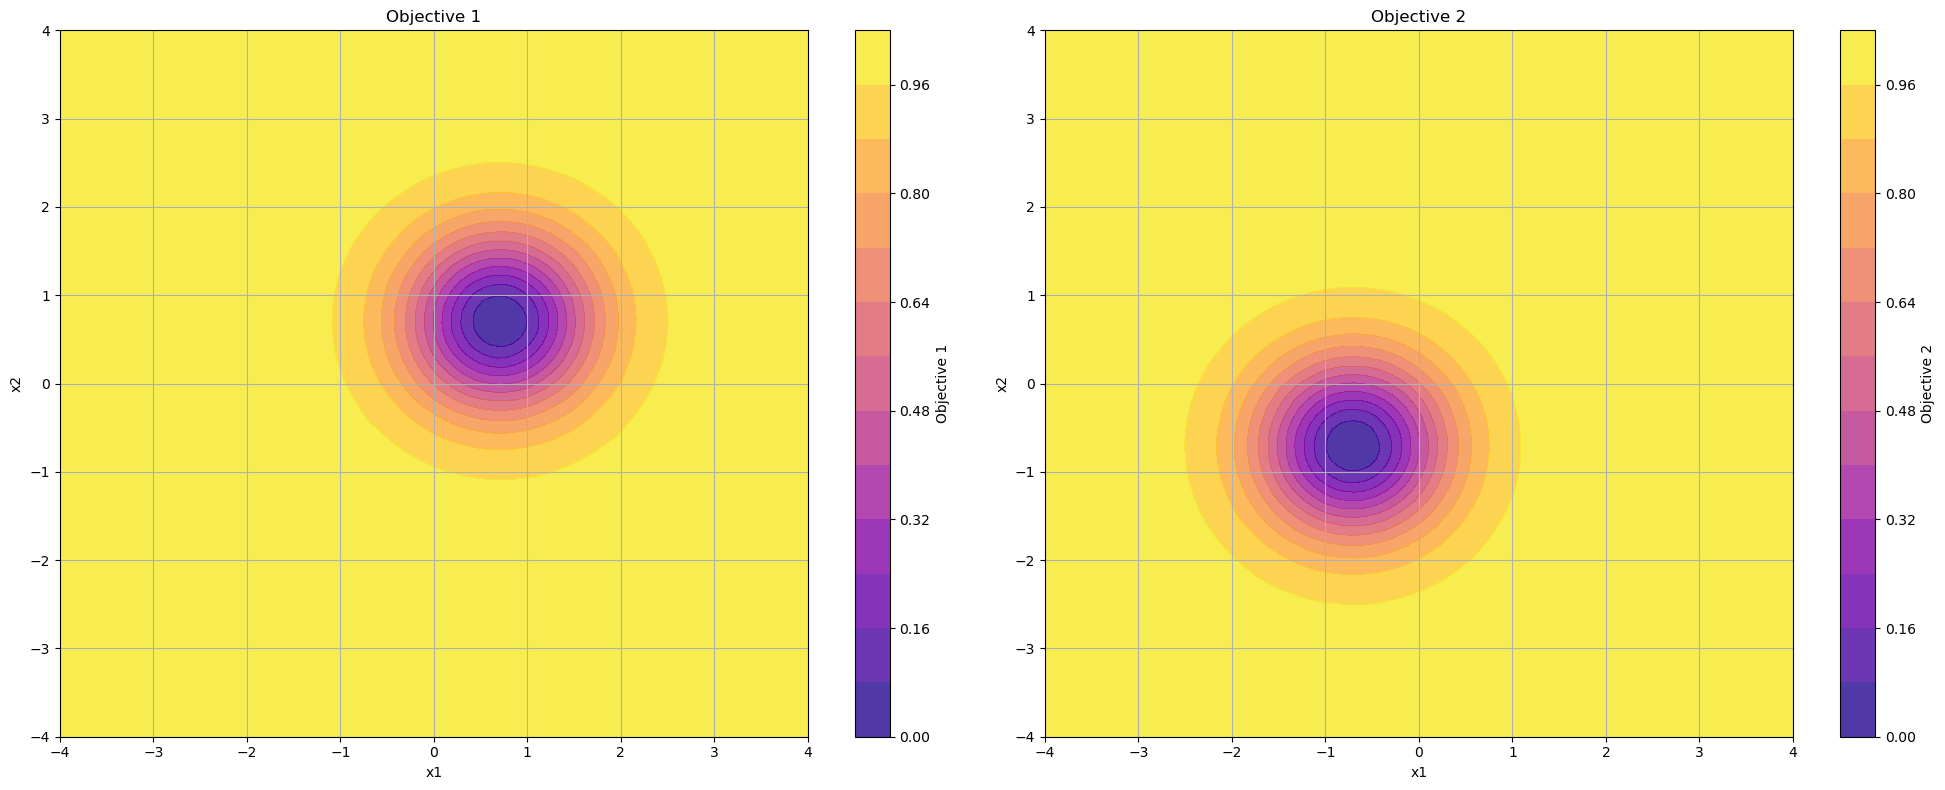

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

grid_size = 100
xi = np.linspace(min(x1), max(x1), grid_size)
yi = np.linspace(min(x2), max(x2), grid_size)
xi_grid, yi_grid = np.meshgrid(xi, yi)

zi1 = griddata((x1, x2), obj1, (xi_grid, yi_grid), method='cubic')
contour1 = ax1.contourf(xi_grid, yi_grid, zi1, 15, cmap='plasma', alpha=0.8)
fig.colorbar(contour1, ax=ax1, label='Objective 1')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Objective 1')
ax1.grid(True)

zi2 = griddata((x1, x2), obj2, (xi_grid, yi_grid), method='cubic')
contour2 = ax2.contourf(xi_grid, yi_grid, zi2, 15, cmap='plasma', alpha=0.8)
fig.colorbar(contour2, ax=ax2, label='Objective 2')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Objective 2')
ax2.grid(True)

min_obj1_idx = np.nanargmin(zi1)
min_obj1_row, min_obj1_col = np.unravel_index(min_obj1_idx, zi1.shape)
min_obj1_x1 = xi_grid[min_obj1_row, min_obj1_col]
min_obj1_x2 = yi_grid[min_obj1_row, min_obj1_col]
min_obj1_value = zi1[min_obj1_row, min_obj1_col]

min_obj2_idx = np.nanargmin(zi2)
min_obj2_row, min_obj2_col = np.unravel_index(min_obj2_idx, zi2.shape)
min_obj2_x1 = xi_grid[min_obj2_row, min_obj2_col]
min_obj2_x2 = yi_grid[min_obj2_row, min_obj2_col]
min_obj2_value = zi2[min_obj2_row, min_obj2_col]

print("Objective 1 Minimum:")
print(f"  Value: {min_obj1_value:.6f}")
print(f"  x1: {min_obj1_x1:.6f}")
print(f"  x2: {min_obj1_x2:.6f}")
print("\nObjective 2 Minimum:")
print(f"  Value: {min_obj2_value:.6f}")
print(f"  x1: {min_obj2_x1:.6f}")
print(f"  x2: {min_obj2_x2:.6f}")

plt.tight_layout()
plt.show()

The minimum for each objectives are at different locations in the decision space. That means we cannot find a single set of decision variables that can make both objectives minimized at the same time. Looks like we have to make a compromise, but how?

Let's have a look at the objective space below. Try to change the values of x1 and x2 to see how the objectives change.

In [5]:
from ipywidgets import interact, FloatSlider

def plot_objectives(x1_val, x2_val):
    # Calculate objectives for the given x1, x2 values using Fonseca-Fleming function
    new_obj1 = 1 - np.exp(-np.sum([(x1_val - 1/np.sqrt(2))**2, (x2_val - 1/np.sqrt(2))**2]))
    new_obj2 = 1 - np.exp(-np.sum([(x1_val + 1/np.sqrt(2))**2, (x2_val + 1/np.sqrt(2))**2]))
    
    # Create the plot
    plt.figure(figsize=(7.5, 6))
    
    # Plot all the original points
    plt.scatter(obj1, obj2, alpha=0.3, label='solutions previously tried')
    
    # Plot the selected point
    plt.scatter(new_obj1, new_obj2, color='red', s=100, label=f'Selected (x1={x1_val:.2f}, x2={x2_val:.2f})')
    
    # Add labels and title
    plt.xlabel('Objective 1 (minimise)')
    plt.ylabel('Objective 2 (minimise)')
    plt.title('Objective Space')
    plt.grid(True)
    plt.legend()
    
    # Display objective values
    plt.annotate(f'Obj1: {new_obj1:.4f}\nObj2: {new_obj2:.4f}', 
                 xy=(new_obj1, new_obj2), 
                 xytext=(10, 10),
                 textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    plt.show()

# Create interactive sliders
interact(plot_objectives, 
         x1_val=FloatSlider(min=-4, max=4, step=0.1, value=0, description='x1:'),
         x2_val=FloatSlider(min=-4, max=4, step=0.1, value=0, description='x2:'))



interactive(children=(FloatSlider(value=0.0, description='x1:', max=4.0, min=-4.0), FloatSlider(value=0.0, des…

<function __main__.plot_objectives(x1_val, x2_val)>

Did you notice that the red dot cannot move all the way down to (0,0)? While the individual minimum for each objectives approach 0, the red dot cannot reach (0,0). In other words, if we want to minimize one objective, it comes at the expense of the other objective.

Keep trying to move the red dot as close to (0,0) as possible. 
Did you notice that you can only move the red dot towards (0,0) up to a certain extent? There seemed to be an invisible line that prevents us from moving the red dot further down. That invisible line is called the "Pareto front". It is the set of points that represent the best trade-off between the two objectives. At any given value of one objective, we can only lower the value of the other objective up to the Pareto front, and vice versa. As decision-makers, we cannot provide absolute happiness for competing interests at the same time, but we can find a set of compromises that make us all relatively happy -- that set of compromises is called the "Pareto optimal set" of decisions. We want a robust collection of these decisions to provide some flexibility.

Can you try finding values for x1 and x2 along that line?

It is difficult and impractical to manually find a robust set of Pareto optimal decisions. Think about these objectives as outputs of a complex numerical model (e.g., groundwater model), which runs hours to evaluate a set of decision inputs and determine the values of the objectives. It will take forever to manually obtain these Pareto optimal decision sets.

The good news is we have decision-support tools to help us with. In the next part of this tutorial, we will show a walk through of PESTPP-MOU, which is one of the tools in the PEST++ suite designed for this purpose.

First, let us make a copy of the directory containing the files we need for this tutorial